In [1]:
# 貼前面寫過的來用
import pandas as pd
url = "https://raw.githubusercontent.com/GrandmaCan/ML/main/Resgression/Salary_Data.csv"
data = pd.read_csv(url)
# y = w*x + b
x=data["YearsExperience"]
y=data["Salary"]
data

,YearsExperience,Salary
0,0.3,36.2
1,0.6,36.6
2,0.8,42.8
3,1.1,39.3
4,1.3,46.2
5,1.5,37.7
6,2.0,43.5
7,2.2,39.8
8,2.9,56.6
9,3.0,60.1


In [2]:
# 分成訓練集與測試集
import torch
from sklearn.model_selection import train_test_split
# 兩成測試集, 固定分割的方式random_state = ?(數字)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 87)
# 原先為Pandas 的形式方便閱讀, 將其用Numpy轉換為矩陣形式方便計算
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# 再將numpy array 轉換為torch tensor
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [3]:
# 透過Pytorch 搭建神經網路
from torch import nn
# 定義名為 LinearRegressionModel 的類別，繼承了 PyTorch 中的 nn.Module 類別
class LinearRegressionModel(nn.Module): # 這表示 LinearRegressionModel 是一個神經網路模型，可以使用 PyTorch 提供的模型相關功能
  def __init__(self): # 這是 LinearRegressionModel 類別的初始化方法
    # 呼叫父類別（nn.Module）的初始化方法
    super().__init__() # super() 是一個內建函數，用來取得父類別的物件，這樣可以確保父類別的初始化方法被正確呼叫
    self.w = nn.Parameter(torch.rand(1, requires_grad=True))
    self.b = nn.Parameter(torch.rand(1, requires_grad=True))
  # 在PyTorch 中，所有的神經網路模型都需要實作一個名為forward的方法，該方法描述了輸入資料如何透過網路層進行計算，最終得到輸出
  def forward(self, x):
    return self.w*x + self.b

In [4]:
# 創建模型
torch.manual_seed(87) # 固定隨機的數值
model = LinearRegressionModel()
# 查看有哪些參數並列成表
model.state_dict() # 也可以用list(model.parameters())

OrderedDict([('w', tensor([0.0036])), ('b', tensor([0.8931]))])

In [5]:
model(x_test) # 將x_test 傳入上方forward, 並執行上方運算

tensor([0.9149, 0.9312, 0.8953, 0.9145, 0.9279, 0.9065, 0.8978],
       dtype=torch.float64, grad_fn=<AddBackward0>)

In [6]:
# 預測與實際差很多
y_pred = model(x_test)
y_pred, y_test

(tensor([0.9149, 0.9312, 0.8953, 0.9145, 0.9279, 0.9065, 0.8978],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([ 93.9000, 121.8000,  36.6000,  81.3000, 112.6000,  57.1000,  46.2000],
        dtype=torch.float64))

In [7]:
# 定義Loss Function(Cost Function)
# https://pytorch.org/docs/stable/nn.html#loss-functions
cost_fn = nn.MSELoss()
y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)

# 原本
print(model.state_dict()) # 印出模型參數
print(cost) # 印出cost

# 使用隨機梯度下降套件, 來做Gradient Descent
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01) # params:傳入參數, lr:Learning Rate
optimizer.zero_grad() # 因為會做疊加, 所以要確保每次計算前歸零
cost.backward() # 讓它自動微分來計算梯度
optimizer.step() # 更新參數

y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)
# 後來
print(model.state_dict()) # 印出模型參數
print(cost) # 印出cost

OrderedDict([('w', tensor([0.0036])), ('b', tensor([0.8931]))])
tensor(5627.4383, dtype=torch.float64, grad_fn=<MseLossBackward0>)
OrderedDict([('w', tensor([8.1354])), ('b', tensor([2.2939]))])
tensor(944.6855, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [8]:
# 讓它不斷更新參數

# Epoch 代表看過所有訓練集一次
epochs = 10000

# 記錄訓練集與測試集的cost
train_cost_hist = []
test_cost_hist = []

# 用上方部分, 建立for 迴圈執行上方程式
for epoch in range(epochs):

  # 養成好習慣, 需寫上model.train() 代表訓練階段
  model.train()
  y_pred = model(x_train)
  train_cost = cost_fn(y_pred, y_train)
  # 記錄訓練集的cost
  train_cost_hist.append(train_cost.detach().numpy()) # detach() 讓它不追蹤梯度並轉成numpy array 格式 (因為無法直接輸出tensor格式)
  optimizer.zero_grad() # 因為會做疊加, 所以要確保每次計算前歸零
  train_cost.backward() # 讓它自動微分來計算梯度
  optimizer.step() # 更新參數

  # 看每次參數的更新在測試集上的表現如何
  # 需寫上model.eval() 代表測試階段
  model.eval()
  with torch.inference_mode(): # 由於是測試集的程式碼無需追蹤梯度，加這行可以提升運算速度
    test_pred = model(x_test)
    test_cost = cost_fn(test_pred, y_test)
    # 記錄測試集的cost
    test_cost_hist.append(test_cost.detach().numpy()) # detach() 讓它不追蹤梯度並轉成numpy array 格式 (因為無法直接輸出tensor格式)

  if epoch%1000==0:
    print(f"Epoch: {epoch:5}, Train Cost: {train_cost: .4e}, Test Cost: {test_cost: .4e}")

Epoch:     0, Train Cost:  9.4469e+02, Test Cost:  3.5138e+02
Epoch:  1000, Train Cost:  3.2599e+01, Test Cost:  3.4706e+01
Epoch:  2000, Train Cost:  3.2594e+01, Test Cost:  3.4187e+01
Epoch:  3000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01
Epoch:  4000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01
Epoch:  5000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01
Epoch:  6000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01
Epoch:  7000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01
Epoch:  8000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01
Epoch:  9000, Train Cost:  3.2594e+01, Test Cost:  3.4185e+01


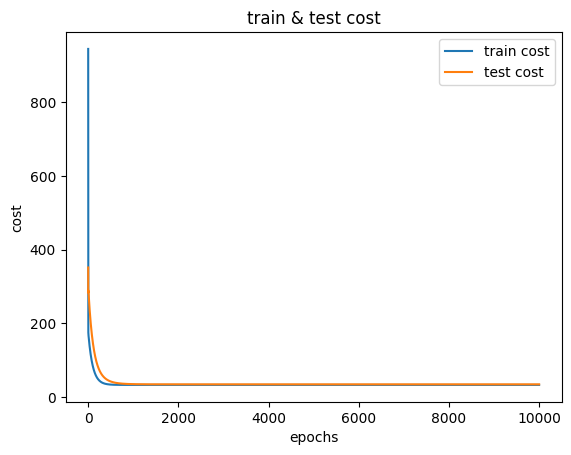

In [9]:
# 畫圖
import matplotlib.pyplot as plt
plt.plot(range(0, 10000), train_cost_hist, label="train cost")
plt.plot(range(0, 10000), test_cost_hist, label="test cost")
plt.title("train & test cost")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

In [10]:
# 找到最後的w 跟b 是多少
model.state_dict() # 同model.w, model.b

OrderedDict([('w', tensor([9.3308])), ('b', tensor([26.6287]))])

In [11]:
# 看看套用最後的w 跟b 到測試集效果
model.eval() # 因為屬於測試階段
with torch.inference_mode():
  y_pred = model(x_test)
y_pred, y_test

(tensor([ 82.6135, 124.6020,  32.2271,  81.6804, 116.2043,  61.1526,  38.7587],
        dtype=torch.float64),
 tensor([ 93.9000, 121.8000,  36.6000,  81.3000, 112.6000,  57.1000,  46.2000],
        dtype=torch.float64))

In [12]:
# 儲存模型 (Save)
torch.save(obj=model.state_dict(), f="Model/pytorch_linear_regression.pth")

In [13]:
# 做一筆新的數據
model_1 = LinearRegressionModel()
model_1.state_dict()

OrderedDict([('w', tensor([0.4548])), ('b', tensor([0.9815]))])

In [14]:
# 載入模型 (Load)
model_1.load_state_dict(torch.load(f="Model/pytorch_linear_regression.pth"))
model_1.state_dict()

OrderedDict([('w', tensor([9.3308])), ('b', tensor([26.6287]))])

In [15]:
# 貼前面寫過的來用
# 看看套用最後的w 跟b 到測試集效果
model_1.eval() # 因為屬於測試階段
with torch.inference_mode():
  y_pred = model_1(x_test)
y_pred, y_test

(tensor([ 82.6135, 124.6020,  32.2271,  81.6804, 116.2043,  61.1526,  38.7587],
        dtype=torch.float64),
 tensor([ 93.9000, 121.8000,  36.6000,  81.3000, 112.6000,  57.1000,  46.2000],
        dtype=torch.float64))

In [16]:
# 應用線性層(Linear Layer) 搭建單層的神經網路做簡單線性回歸

# 貼前面寫過的來用
# 透過Pytorch 搭建神經網路
from torch import nn
# 定義名為 LinearRegressionModel 的類別，繼承了 PyTorch 中的 nn.Module 類別
class LinearRegressionModel2(nn.Module): # 這表示 LinearRegressionModel2 是一個神經網路模型，可以使用 PyTorch 提供的模型相關功能
  def __init__(self): # 這是 LinearRegressionModel2 類別的初始化方法
    # 呼叫父類別（nn.Module）的初始化方法
    super().__init__() # super() 是一個內建函數，用來取得父類別的物件，這樣可以確保父類別的初始化方法被正確呼叫

    # 簡單線性回歸如同只有單層的神經網路,因此先創建一單層線性層 (單層的神經網路), 功能同原先以下註解兩行
    # self.w = nn.Parameter(torch.rand(1, requires_grad=True))
    # self.b = nn.Parameter(torch.rand(1, requires_grad=True))
    # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
    self.linear_layer = nn.Linear(in_features=1, out_features=1, dtype=torch.float64) # in_features: 輸入個數, out_features: 輸出個數, bias: 預設為true, dtype: 設定

  # 在PyTorch 中，所有的神經網路模型都需要實作一個名為forward的方法，該方法描述了輸入資料如何透過網路層進行計算，最終得到輸出
  def forward(self, x):
    return self.linear_layer(x)

In [17]:
torch.manual_seed(87) # 固定隨機的數值
model_2 = LinearRegressionModel2()
model_2, model_2.state_dict()

(LinearRegressionModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[-0.9419]], dtype=torch.float64)),
              ('linear_layer.bias', tensor([0.2761], dtype=torch.float64))]))

In [18]:
x_train = x_train.reshape(-1, 1) # x_train.reshape(26,1) = x_train.reshape(-1,1), -1: 系統會自動調整
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [19]:
# 矩陣大小與資料型態問題Debug: https://www.youtube.com/watch?v=uc4LbsAA3IU
# 貼前面寫過的來用
# 定義Loss Function(Cost Function)
# https://pytorch.org/docs/stable/nn.html#loss-functions
cost_fn = nn.MSELoss()
y_pred = model_2(x_train)
cost = cost_fn(y_pred, y_train)

# 原本
print(model_2.state_dict()) # 印出模型參數
print(cost) # 印出cost

# 使用隨機梯度下降套件, 來做Gradient Descent
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01) # params:傳入參數, lr:Learning Rate
optimizer.zero_grad() # 因為會做疊加, 所以要確保每次計算前歸零
cost.backward() # 讓它自動微分來計算梯度
optimizer.step() # 更新參數

y_pred = model_2(x_train)
cost = cost_fn(y_pred, y_train)
# 後來
print(model_2.state_dict()) # 印出模型參數
print(cost) # 印出cost

OrderedDict([('linear_layer.weight', tensor([[-0.9419]], dtype=torch.float64)), ('linear_layer.bias', tensor([0.2761], dtype=torch.float64))])
tensor(6515.9517, dtype=torch.float64, grad_fn=<MseLossBackward0>)
OrderedDict([('linear_layer.weight', tensor([[7.8250]], dtype=torch.float64)), ('linear_layer.bias', tensor([1.7790], dtype=torch.float64))])
tensor(1074.6975, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [20]:
# 貼前面寫過的來用
# 讓它不斷更新參數

# Epoch 代表看過所有訓練集一次
epochs = 10000

# 記錄訓練集與測試集的cost
train_cost_hist = []
test_cost_hist = []

# 用上方部分, 建立for 迴圈執行上方程式
for epoch in range(epochs):

  # 養成好習慣, 需寫上model.train() 代表訓練階段
  model_2.train()
  y_pred = model_2(x_train)
  train_cost = cost_fn(y_pred, y_train)
  # 記錄訓練集的cost
  train_cost_hist.append(train_cost.detach().numpy()) # detach() 讓它不追蹤梯度並轉成numpy array 格式 (因為無法直接輸出tensor格式)
  optimizer.zero_grad() # 因為會做疊加, 所以要確保每次計算前歸零
  train_cost.backward() # 讓它自動微分來計算梯度
  optimizer.step() # 更新參數

  # 看每次參數的更新在測試集上的表現如何
  # 需寫上model.eval() 代表測試階段
  model_2.eval()
  with torch.inference_mode(): # 由於是測試集的程式碼無需追蹤梯度，加這行可以提升運算速度
    test_pred = model_2(x_test)
    test_cost = cost_fn(test_pred, y_test)
    # 記錄測試集的cost
    test_cost_hist.append(test_cost.detach().numpy()) # detach() 讓它不追蹤梯度並轉成numpy array 格式 (因為無法直接輸出tensor格式)

  if epoch%1000==0:
    print(f"Epoch: {epoch:5}, Train Cost: {train_cost: .4e}, Test Cost: {test_cost: .4e}")

Epoch:     0, Train Cost:  1.0747e+03, Test Cost:  3.7437e+02
Epoch:  1000, Train Cost:  3.2600e+01, Test Cost:  3.4717e+01
Epoch:  2000, Train Cost:  3.2594e+01, Test Cost:  3.4187e+01
Epoch:  3000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  4000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  5000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  6000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  7000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  8000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  9000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01


In [21]:
model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[9.3308]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([26.6288], dtype=torch.float64))])

In [22]:
# 顯示GPU 型號
!nvidia-smi

Tue Jan 30 14:12:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
# Torch 是否連接到GPU
torch.cuda.is_available()

True

In [24]:
torch.cuda.device_count()

1

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
tensor = torch.tensor([1, 2, 3], device=device) # 或tensor = tensor.to(device)
tensor, tensor.device

(tensor([1, 2, 3], device='cuda:0'), device(type='cuda', index=0))

In [27]:
# GPU 上創建模型

model_3 = LinearRegressionModel2()
model_3.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2918]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([-0.2794], dtype=torch.float64))])

In [28]:
model_3.linear_layer.bias.device, model_3.linear_layer.weight.device

(device(type='cpu'), device(type='cpu'))

In [29]:
model_3.to(device)
model_3.linear_layer.bias.device, model_3.linear_layer.weight.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [30]:
# 設定到GPU 上訓練模型
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

In [31]:
# 貼前面寫過的來用
cost_fn = nn.MSELoss()
y_pred = model_3(x_train)
cost = cost_fn(y_pred, y_train)
print(model_3.state_dict())
print(cost)

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred = model_3(x_train)
cost = cost_fn(y_pred, y_train)
print(model_3.state_dict())
print(cost)

OrderedDict([('linear_layer.weight', tensor([[-0.2918]], device='cuda:0', dtype=torch.float64)), ('linear_layer.bias', tensor([-0.2794], device='cuda:0', dtype=torch.float64))])
tensor(6039.2049, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
OrderedDict([('linear_layer.weight', tensor([[8.1315]], device='cuda:0', dtype=torch.float64)), ('linear_layer.bias', tensor([1.1729], device='cuda:0', dtype=torch.float64))])
tensor(1014.4567, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


In [32]:
# 貼前面寫過的來用
epochs = 10000

train_cost_hist = []
test_cost_hist = []

for epoch in range(epochs):

  model_3.train()

  y_pred = model_3(x_train)

  train_cost = cost_fn(y_pred, y_train)
  train_cost_hist.append(train_cost.cpu().detach().numpy()) # 將train_cost 設定到cpu() 上

  optimizer.zero_grad()

  train_cost.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_pred = model_3(x_test)
    test_cost = cost_fn(test_pred, y_test)
    test_cost_hist.append(test_cost.cpu()) # 將test_cost 設定到cpu() 上

  if epoch%1000==0:
    print(f"Epoch: {epoch:5}, Train Cost: {train_cost: .4e}, Test Cost: {test_cost: .4e}")

Epoch:     0, Train Cost:  1.0145e+03, Test Cost:  3.7527e+02
Epoch:  1000, Train Cost:  3.2600e+01, Test Cost:  3.4731e+01
Epoch:  2000, Train Cost:  3.2594e+01, Test Cost:  3.4187e+01
Epoch:  3000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  4000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  5000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  6000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  7000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  8000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01
Epoch:  9000, Train Cost:  3.2594e+01, Test Cost:  3.4184e+01


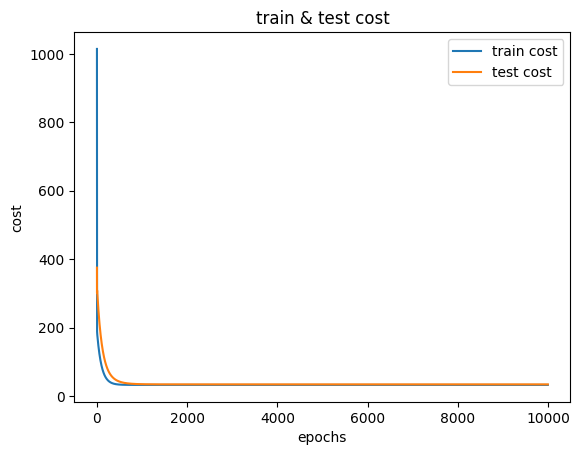

In [38]:
# 貼前面寫過的來用
# 畫圖
import matplotlib.pyplot as plt
plt.plot(range(0, 10000), train_cost_hist, label="train cost")
plt.plot(range(0, 10000), test_cost_hist, label="test cost")
plt.title("train & test cost")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

In [39]:
# 貼前面寫過的來用
# 儲存模型 (Save)
model_3.state_dict()
torch.save(obj=model_3.state_dict(), f="Model/pytorch_linear_regression_2.pth")

In [40]:
# 貼前面寫過的來用
# 做一筆新的數據
model_4 = LinearRegressionModel2()
model_4.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.6328]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([0.6519], dtype=torch.float64))])

In [41]:
# 貼前面寫過的來用
# 載入模型 (Load)
model_4.load_state_dict(torch.load(f="Model/pytorch_linear_regression_2.pth"))
model_4.state_dict()

OrderedDict([('linear_layer.weight', tensor([[9.3308]], dtype=torch.float64)),
             ('linear_layer.bias', tensor([26.6288], dtype=torch.float64))])

In [43]:
# 貼前面寫過的來用
# 看看套用最後的w 跟b 到測試集效果
model_4.to(device) # 移到GPU 上
model_4.eval()
with torch.inference_mode():
  y_pred = model_4(x_test)
y_pred, y_test

(tensor([[ 82.6135],
         [124.6019],
         [ 32.2273],
         [ 81.6804],
         [116.2042],
         [ 61.1527],
         [ 38.7588]], device='cuda:0', dtype=torch.float64),
 tensor([[ 93.9000],
         [121.8000],
         [ 36.6000],
         [ 81.3000],
         [112.6000],
         [ 57.1000],
         [ 46.2000]], device='cuda:0', dtype=torch.float64))